In [ ]:
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
##############################################     Create the simulated data set            ##################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################

In [1]:
# !pip install causalml
from causalml.dataset import synthetic_data
import pandas as pd
import numpy as np

np.random.seed(1)



y, X, treatment, ite, b, e = synthetic_data(mode=1, n=5000, p=5, sigma=1, adj=0)
treatment = np.array([0 if np.random.random() < 0.33 else 1 if np.random.random() < 0.66  else 2 for _ in treatment])
y = np.where(y > 0.5, 1, 0)

X_df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
y_df = pd.DataFrame(y, columns=['target'])
treatment_df = pd.DataFrame(treatment, columns=['treatment'])
data = pd.concat([X_df, y_df, treatment_df], axis=1)
data.to_csv('synthetic_data.csv', index=False)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
##############################################     All the utils           ######################################################################
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################

In [1]:
##############################################################################################################################################
#####################       Evaluation metrics       #########################################################################################
##############################################################################################################################################


expected_outcome <- function(pred, response, control, treatment_list) {
  N <- nrow(pred)
  for (t in c(treatment_list, control)) {
    assign(paste(t, "prob", sep = "_"), sum(pred$Assignment == t) / N)
  }
  temp_function <- function(x) {
    if (x["Assignment"] == x["Treatment"]) {
      return(as.numeric(x["Outcome"]) / eval(as.name(paste(x["Treatment"], "prob", sep = "_"))))
    } else {
      return(0)
    }
  }
  results <- sum(apply(pred, 1, temp_function))
  return(results / N)
}



# Modified Uplift Curve by Zhao
expected_outcome_curve <- function(response, control, treatment_list, predictions, model_name = "None") {
  predictions$max_uplift <- apply(predictions[, grep("^uplift", colnames(predictions))], 1, max)
  sorted_predictions <- predictions[order(-predictions$max_uplift), ]
  sorted_predictions$Treatment <- as.character(sorted_predictions$Treatment)
  sorted_predictions$Assignment <- as.character(sorted_predictions$Assignment)
  sorted_predictions$temp_pred <- sorted_predictions$Treatment
  n_tenth <- round(nrow(predictions) / 10)
  sorted_predictions$Treatment <- control
  deciles <- c(expected_outcome(sorted_predictions, response, control, treatment_list))
  for (x in 1:9) {
    sorted_predictions$Treatment <- sorted_predictions$temp_pred
    sorted_predictions$Treatment[(x * n_tenth):nrow(sorted_predictions)] <- control
    deciles <- c(deciles, expected_outcome(sorted_predictions, response, control, treatment_list))
  }
  sorted_predictions$Treatment <- sorted_predictions$temp_pred
  deciles <- c(deciles, expected_outcome(sorted_predictions, response, control, treatment_list))
  result <- data.frame(t(deciles))
  colnames(result) <- seq(0,100,10)
  result$Model <- model_name
  return(result)
}




# Given a prediction, this function checks how many what percentage of people where assigned a treatment
# by the model
perc_treated <- function(pred, treatment_list, n_pred = NULL) {
  perc <- c()
  for (t in treatment_list) {
    if (is.null(n_pred)) {
      perc <- c(perc, sum(pred$Treatment == t) / nrow(pred))
    } else {
      perc <- c(perc, sum(pred$Treatment == t) / n_pred)
    }
  }
  return(perc * 100)
}

decile_perc_treated <- function(pred, treatment_list, model_name = "None") {
  pred$max_uplift <- apply(pred[, grep("^uplift", colnames(pred))], 1, max)
  sorted_predictions <- pred[order(-pred$max_uplift), ]
  perc <- c()
  n_tenth <- round(nrow(pred) / 10)
  for (x in 1:9) {
    perc <- rbind(perc, cbind(
      perc_treated(sorted_predictions[1:(x * n_tenth), ], treatment_list, nrow(pred)),
      treatment_list, rep(x*10, length(treatment_list))
    ))
  }
  perc <- rbind(perc, cbind(
    perc_treated(sorted_predictions, treatment_list), treatment_list,
    rep(100, length(treatment_list))
  ))
  perc <- data.frame(perc)
  colnames(perc) <- c("PercTreated", "Treatment", "Decile")
  perc$Model <- model_name
  perc$PercTreated <- as.numeric(as.character(perc$PercTreated))
  perc$Decile <- as.numeric(as.character(perc$Decile))
  return(perc)
}




# Given a prediction, this function calculates the percentage of people assigned a treatment by the model, for
# each decile.
n_treated_decile <- function(pred, control) {
  pred$max_uplift <- apply(pred[, grep("^uplift", colnames(pred))], 1, max)
  sorted_predictions <- pred[order(-pred$max_uplift), ]
  n_tenth <- round(nrow(pred) / 10)
  treated <- c(0)
  for (x in 1:9) {
    temp_data <- sorted_predictions[1:(n_tenth * x), ]
    treated <- c(treated, sum(temp_data$Treatment != control))
  }
  temp_data <- sorted_predictions
  treated <- c(treated, sum(temp_data$Treatment != control))
  return(treated)
}






# Incremental Uplift Curve
uplift_curve <- function(predictions, control_level, treatments) {
  # score for each T individually
  N_total <- nrow(predictions)

  c_group <- predictions[predictions$Assignment == control_level, ]
  N_c <- nrow(c_group)

  ret <- data.frame(Percentile = seq(0, 1, 0.1))

  tmp <- predictions[predictions$Assignment != control_level, ]

  # score by max T
  tmp$max_uplift <- apply(tmp[, grep("^uplift", colnames(tmp))], 1, max)
  c_group$max_uplift <- apply(c_group[, grep("^uplift", colnames(c_group))], 1, max)

  tmp <- tmp[order(tmp[, "max_uplift"], decreasing = T), ]
  c_tmp <- c_group[order(c_group[, "max_uplift"], decreasing = T), ]

  N_t <- nrow(tmp)

  outcomes <- c()
  # For each decile
  for (x in seq(0, 1, 0.1)) {

    # Formula from Gutierrez 2017
    weighted_uplift <- (mean(head(tmp$Outcome, x * N_t)) - mean(head(c_tmp$Outcome, x * N_c))) * (N_total * x)

    outcomes <- c(outcomes, weighted_uplift)
  }
  ret$combined <- outcomes


  ret[is.na(ret)] <- 0

  return(ret)
}





# incremental Qini - Curve
qini_curve <- function(predictions, control_level, treatments, model_name = "None") {
  # score for each T individually
  predictions$max_uplift <- apply(predictions[, grep("^uplift", colnames(predictions))], 1, max)
  c_group <- predictions[predictions$Assignment == control_level, ]
  N_c <- nrow(c_group)



  ret <- data.frame(Percentile = seq(0, 100, 10))
  tmp <- predictions[predictions$Assignment != control_level, ]

  # score by uplift column of T
  tmp <- tmp[order(tmp[, "max_uplift"], decreasing = T), ]
  c_tmp <- c_group[order(c_group[, "max_uplift"], decreasing = T), ]

  N_t <- nrow(tmp)

  outcomes <- c(0)
  # For each decile
  for (x in seq(0.1, 1, 0.1)) {
    # Radcliffe 2007
    # u = R_t - ((R_c * N_t) / N_c)
    qini_gain <- sum(head(tmp$Outcome, x * N_t)) - ((sum(head(c_tmp$Outcome, x * N_c)) * (x * N_t)) / (x * N_c))

    outcomes <- c(outcomes, qini_gain)
  }
  ret$Values <- outcomes
  result <- ret
  result[is.na(result)] <- 0
  result$Model <- model_name
  return(result)
}


# Percent Matched
perc_matched <- function(predictions) {
  predictions$max_uplift <- apply(predictions[, grep("^uplift", colnames(predictions))], 1, max)
  sorted_predictions <- predictions[order(-predictions$max_uplift), ]
  sorted_predictions$Treatment <- as.character(sorted_predictions$Treatment)
  n_tenth <- round(nrow(predictions) / 10)
  deciles <- c()
  for (x in 1:9) {
    if (x == 1) {
      new_data <- sorted_predictions[1:n_tenth, ]
      deciles <- c(deciles, sum(new_data$Treatment == new_data$Assignment) / nrow(new_data))
    } else {
      new_data <- sorted_predictions[((x - 1) * n_tenth):(x * n_tenth), ]
      deciles <- c(deciles, sum(new_data$Treatment == new_data$Assignment) / nrow(new_data))
    }
  }
  new_data <- sorted_predictions[(9 * n_tenth):nrow(sorted_predictions), ]
  deciles <- c(deciles, sum(new_data$Treatment == new_data$Assignment) / nrow(new_data))
  return(deciles)
}

In [ ]:
###############################################################################################################################################
#####################       Visualisation       ###############################################################################################
###############################################################################################################################################

In [2]:
# install.packages("DiagrammeR")
# install.packages("gridExtra")
# install.packages("plyr")



In [3]:
library("DiagrammeR")
library("gridExtra")
library("plyr")
# This method visualizes the incremental expected outcome for one or more models.
# If there are multiple predictions for each model, the function aggregates those predictions and can create
# errorbars to show the confidence interval of the predictions.
visualize_outcome <- function(temp_data, ylabel = "Y", n_treated = NULL, errorbars = F, multiplot = FALSE) {
  values <- c()
  percentile <- c()
  model <- c()
  for (f in 1:nrow(temp_data)) {
    if (length(values) == 0) {
      values <- temp_data[f, 1:11]
      percentile <- colnames(temp_data)[1:11]
      model <- rep(temp_data[f, 12], 11)
    } else {
      values <- c(values, temp_data[f, 1:11])
      percentile <- c(percentile, colnames(temp_data)[1:11])
      model <- c(model, rep(temp_data[f, 12], 11))
    }
  }
  temp_df <- data.frame(cbind(values, percentile, model))
  rownames(temp_df) <- 1:nrow(temp_df)
  colnames(temp_df) <- c("values", "percentile", "Model")
  for (c in 1:2) {
    temp_df[, c] <- as.numeric(as.character(temp_df[, c]))
  }
  temp_df[, 3] <- as.character(temp_df[, 3])
  tgc <- summarySE(data = temp_df, measurevar = "values", groupvars = c("percentile", "Model"))
  pd <- position_dodge(1) # move them .05 to the left and right
  p1 <- ggplot(tgc, aes(x = percentile, y = mean, color = Model)) +
    {
      if (errorbars && sum(is.na(tgc)) == 0) geom_errorbar(aes(ymin = mean - ci, ymax = mean + ci), position = pd)
    } +
    geom_line() +
    geom_point() +
    scale_x_continuous(
      name = "Percent assigned according to Model Prediction",
      breaks = seq(0, 100, 10)
    ) +
    ylab(ylabel) +
    theme(
      axis.text = element_text(size = 14),
      axis.title = element_text(size = 16),
      legend.title = element_text(size = 16),
      legend.text = element_text(size = 14)
    ) +
    {
      if (multiplot) facet_wrap(~Model)
    } +
    {
      if (multiplot) {
        theme(
          legend.position = "none",
          strip.text.x = element_text(size = 12)
        )
      }
    }
  # ggtitle("Mean and Confidence Interval for Expected Outcome")
  if (!is.null(n_treated)) {
    agg_df <- aggregate(n_treated$PercTreated,
      by = list(n_treated$Treatment, n_treated$Model, n_treated$Decile),
      FUN = mean
    )
    colnames(agg_df) <- c("Treatment", "Model", "Decile", "PercTreated")
    p2 <- ggplot(agg_df, aes(fill = Treatment, y = PercTreated, x = Decile)) +
      geom_bar(position = "stack", stat = "identity") +
      scale_x_continuous(
        name = "Percent assigned according to Model Prediction",
        breaks = seq(0, 100, 10)
      ) +
      scale_y_continuous(
        name = "Treatment Percentage",
        breaks = seq(0, 100, 10)
      ) +
      theme(
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16),
        strip.text.x = element_text(size = 10),
        legend.title = element_text(size = 16),
        legend.text = element_text(size = 14)
      ) +
      facet_wrap(~Model)
    print(p1)
    print(p2)
  } else {
    print(p1)
  }
}






outcome_boxplot <- function(temp_data, ylabel) {
  values <- c()
  percentile <- c()
  model <- c()
  for (f in 1:nrow(temp_data)) {
    if (length(values) == 0) {
      values <- temp_data[f, 1:10]
      percentile <- colnames(temp_data)[1:10]
      model <- rep(temp_data[f, 11], 10)
    } else {
      values <- c(values, temp_data[f, 1:10])
      percentile <- c(percentile, colnames(temp_data)[1:10])
      model <- c(model, rep(temp_data[f, 11], 10))
    }
  }
  new_percentile <- c()
  for (p in percentile) {
    new_percentile <- c(new_percentile, paste(as.character(p), "% treated according to model prediction", sep = ""))
  }
  temp_df <- data.frame(cbind(values, new_percentile, model))
  rownames(temp_df) <- 1:nrow(temp_df)
  colnames(temp_df) <- c("values", "percentile", "Model")
  temp_df[, 1] <- as.numeric(as.character(temp_df[, 1]))
  temp_df[, 2] <- as.character(temp_df[, 2])
  temp_df[, 3] <- as.character(temp_df[, 3])
  temp_df <- transform(temp_df, percentile = factor(percentile, levels = unique(temp_df$percentile)))
  p1 <- ggplot(temp_df, aes(y = values, x = Model, color = Model)) +
    geom_boxplot() +
    ylab(ylabel) +
    xlab("") +
    facet_wrap(~percentile)
  p1 <- p1 + theme(
    axis.text = element_text(size = 14),
    axis.title = element_text(size = 16),
    axis.ticks.x = element_blank(),
    axis.text.x = element_blank(),
    legend.title = element_text(size = 16),
    legend.text = element_text(size = 14),
    strip.text.x = element_text(size = 10)
  )
  print(p1)
}






visualize_qini <- function(temp_data, ylabel = "y", multiple_predictions = F, errorbars = F, multiplot = F) {
  values <- c()
  percentile <- c()
  model <- c()
  temp_df <- temp_data
  if (multiple_predictions) {
    tgc <- summarySE(data = temp_df, measurevar = "Values", groupvars = c("Percentile", "Model"))
    if (errorbars) {
      print(ggplot(tgc, aes(x = Percentile, y = mean, color = Model)) +
        geom_errorbar(aes(ymin = mean - ci, ymax = mean + ci)) +
        geom_line() +
        geom_point() +
        scale_x_continuous(
          name = "Percent assigned according to Model Prediction",
          limits = c(0, 100), breaks = seq(0, 100, 10)
        ) +
        ylab(ylabel) +
        {
          if (multiplot) facet_wrap(~Model)
        } +
        {
          if (multiplot) theme(legend.position = "none")
        })
      # ggtitle(paste("Mean and Confidence Interval for",type,"score",sep=" ")))
    } else {
      print(ggplot(tgc, aes(x = Percentile, y = mean, color = Model)) +
        geom_line() +
        geom_point() +
        scale_x_continuous(
          name = "Percent assigned according to Model Prediction",
          limits = c(0, 100), breaks = seq(0, 100, 10)
        ) +
        ylab(ylabel) +
        theme(
          axis.text = element_text(size = 14),
          axis.title = element_text(size = 16),
          legend.title = element_text(size = 16),
          legend.text = element_text(size = 14)
        ) +
        {
          if (multiplot) facet_wrap(~Model)
        } +
        {
          if (multiplot) theme(legend.position = "none")
        })
    }
  } else {
    print(ggplot(temp_df, aes(x = Percentile, y = Values, color = Model)) +
      geom_line() +
      geom_point() +
      scale_x_continuous(
        name = "Percent assigned according to Model Prediction",
        limits = c(0, 100), breaks = seq(0, 100, 10)
      ) +
      theme(
        axis.text = element_text(size = 14),
        axis.title = element_text(size = 16)
      ) +
      ylab(ylabel) +
      {
        if (multiplot) facet_wrap(~Model)
      } +
      {
        if (multiplot) theme(legend.position = "none")
      })
  }
}









# Function used to aggregate multiple predictions for the same model.
summarySE <- function(data = NULL, measurevar, groupvars = NULL, na.rm = FALSE,
                      conf.interval = .95, .drop = TRUE) {


  # New version of length which can handle NA's: if na.rm==T, don't count them
  length2 <- function(x, na.rm = FALSE) {
    if (na.rm) {
      sum(!is.na(x))
    } else {
      length(x)
    }
  }

  # This does the summary. For each group's data frame, return a vector with
  # N, mean, and sd
  datac <- ddply(data, groupvars,
    .drop = .drop,
    .fun = function(xx, col) {
      c(
        N = length2(xx[[col]], na.rm = na.rm),
        mean = mean(xx[[col]], na.rm = na.rm),
        sd = sd(xx[[col]], na.rm = na.rm)
      )
    },
    measurevar
  )

  datac$se <- datac$sd / sqrt(datac$N) # Calculate standard error of the mean

  # Confidence interval multiplier for standard error
  # Calculate t-statistic for confidence interval:
  # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
  ciMult <- qt(conf.interval / 2 + .5, datac$N - 1)
  datac$ci <- datac$se * ciMult

  return(datac)
}










# Methods used to plot a tree
# It is advisable to build a shallow tree (low value for max_depth) to make the graph somewhat readable.
visualize_tree <- function(tree, only_split = F, result_digits = 2, result_multiplicator = 1) {
  plot_list <- get_plot_params(tree)
  plot_list[[4]] <- round(plot_list[[4]] * result_multiplicator, result_digits)
  plot_string <- "digraph flowchart {  \n node [fontname = Helvetica, shape = rectangle]"

  label <- ""
  split_counter <- 1
  if (only_split) {
    for (x in 1:length(plot_list[[1]])) {
      if (!(plot_list[[1]][x]) == "leaf") {
        label <- paste(label, paste(as.character(plot_list[[5]][x]), "[label = '",
          "Split", names(plot_list[[2]][split_counter]), as.character(plot_list[[2]][[split_counter]]),
          "'] \n",
          sep = " "
        ), sep = "")
        split_counter <- split_counter + 1
      } else {
        label <- paste(label, paste(as.character(plot_list[[5]][x]), "[label = '", plot_list[[1]][x], "\n",
          "Number of Samples", as.character(plot_list[[3]][x]), "\n",
          names(plot_list[[4]][((x - 1) * 3 + 1)]), as.character(plot_list[[4]][[((x - 1) * 3 + 1)]]), "\n",
          names(plot_list[[4]][((x - 1) * 3 + 2)]), as.character(plot_list[[4]][[((x - 1) * 3 + 2)]]), "\n",
          names(plot_list[[4]][((x - 1) * 3 + 3)]), as.character(plot_list[[4]][[((x - 1) * 3 + 3)]]), "\n",
          "'] \n",
          sep = " "
        ), sep = "")
      }
    }
  } else {
    for (x in 1:length(plot_list[[1]])) {
      if (!(plot_list[[1]][x]) == "leaf") {
        label <- paste(label, paste(as.character(plot_list[[5]][x]), "[label = '", plot_list[[1]][x], "\n",
          "Split", names(plot_list[[2]][split_counter]), as.character(plot_list[[2]][[split_counter]]), "\n",
          "Number of Samples", as.character(plot_list[[3]][x]), "\n",
          names(plot_list[[4]][((x - 1) * 3 + 1)]), as.character(plot_list[[4]][[((x - 1) * 3 + 1)]]), "\n",
          names(plot_list[[4]][((x - 1) * 3 + 2)]), as.character(plot_list[[4]][[((x - 1) * 3 + 2)]]), "\n",
          names(plot_list[[4]][((x - 1) * 3 + 3)]), as.character(plot_list[[4]][[((x - 1) * 3 + 3)]]), "\n",
          "'] \n",
          sep = " "
        ), sep = "")
        split_counter <- split_counter + 1
      } else {
        label <- paste(label, paste(as.character(plot_list[[5]][x]), "[label = '", plot_list[[1]][x], "\n",
          "Number of Samples", as.character(plot_list[[3]][x]), "\n",
          names(plot_list[[4]][((x - 1) * 3 + 1)]), as.character(plot_list[[4]][[((x - 1) * 3 + 1)]]), "\n",
          names(plot_list[[4]][((x - 1) * 3 + 2)]), as.character(plot_list[[4]][[((x - 1) * 3 + 2)]]), "\n",
          names(plot_list[[4]][((x - 1) * 3 + 3)]), as.character(plot_list[[4]][[((x - 1) * 3 + 3)]]), "\n",
          "'] \n",
          sep = " "
        ), sep = "")
      }
    }
  }
  links <- paste(plot_list[[6]], collapse = "; \n ")

  print(grViz(paste(plot_string, label, links, "}", sep = "\n")))
}






# Helperfunction for the tree visualization.
get_plot_params <- function(tree, counter = 0) {
  type_list <- c(tree[["type"]])
  split_list <- c(tree[["split"]])
  n_sample_list <- c(tree[["n_samples"]])
  results_list <- c(tree[["results"]])
  counter_list <- c(counter)
  connection_list <- c()
  if (!is.null(tree[["left"]])) {
    temp_list <- get_plot_params(tree[["left"]], counter = counter + 1)
    type_list <- c(type_list, temp_list[[1]])
    split_list <- c(split_list, temp_list[[2]])
    n_sample_list <- c(n_sample_list, temp_list[[3]])
    results_list <- c(results_list, temp_list[[4]])
    counter_list <- c(counter_list, temp_list[[5]])
    connection_list <- c(paste(as.character(counter), "->", as.character(temp_list[[5]][1]), sep = " "))
    if (length(temp_list) > 5) {
      connection_list <- c(connection_list, temp_list[[6]])
    }
  }
  if (!is.null(tree[["right"]])) {
    temp_list <- get_plot_params(tree[["right"]], counter = max(counter_list) + 1)
    type_list <- c(type_list, temp_list[[1]])
    split_list <- c(split_list, temp_list[[2]])
    n_sample_list <- c(n_sample_list, temp_list[[3]])
    results_list <- c(results_list, temp_list[[4]])
    counter_list <- c(counter_list, temp_list[[5]])
    connection_list <- c(connection_list, paste(as.character(counter), "->", as.character(temp_list[[5]][1]), sep = " "))
    if (length(temp_list) > 5) {
      connection_list <- c(connection_list, temp_list[[6]])
    }
  }
  result_list <- list()
  result_list[[1]] <- type_list
  result_list[[2]] <- split_list
  result_list[[3]] <- n_sample_list
  result_list[[4]] <- results_list
  result_list[[5]] <- counter_list
  result_list[[6]] <- connection_list
  return(result_list)
}

In [4]:
################################################################################################################################################
################################################################################################################################################
################################################################################################################################################
#############################################    The predictions functions    ###################################################################
##################################################################################################################################################
################################################################################################################################################
################################################################################################################################################

predict.dt.as.df <- function(tree, new_data, treatment_list, control, additional_info = TRUE) {
  type_list <- sapply(new_data, class)
  names(type_list) <- colnames(new_data)
  temp_function <- function(x, node) {
    type <- node[["type"]]
    while (type != "leaf") {
      split <- node[["split"]]
      if (type_list[[names(split)]] == "factor") {
        if (x[names(split)] == split[[1]]) {
          node <- node[["left"]]
          type <- node[["type"]]
        } else {
          node <- node[["right"]]
          type <- node[["type"]]
        }
      } else {
        if (as.numeric(x[names(split)]) < split[[1]]) {
          node <- node[["left"]]
          type <- node[["type"]]
        } else {
          node <- node[["right"]]
          type <- node[["type"]]
        }
      }
    }
    return(node[["results"]])
  }
  results <- data.frame(t(apply(new_data, 1, temp_function, node = tree)))
  if (additional_info) {
    colnames(results) <- c(treatment_list, control)
    results[, "Treatment"] <- predictions_to_treatment(results, treatment_list, control)
    results[, "Assignment"] <- predictions_to_treatment(new_data, treatment_list, control)
    results[, "Outcome"] <- new_data[, response]
    for (t in treatment_list) {
      results[, paste("uplift", t, sep = "_")] <- results[t] - results[control]
    }
    return(results)
  } else {
    return(results)
  }
}


# Takes predictions as input and returns just the name of the best treatment for each prediction

predictions_to_treatment <- function(pred, treatment_list, control) {
  temp_list <- c()
  results <- colnames(pred[, c(treatment_list, control)])[apply(pred[, c(treatment_list, control)], 1, which.max)]
  # If all uplifts are 0, we assign control
  for (c in treatment_list) {
    if (length(temp_list) == 0) {
      temp_list <- pred[c]
    } else {
      temp_list <- temp_list + pred[, c]
    }
  }
  if (sum(temp_list == 0) > 0) {
    results[temp_list == 0] <- control
  }
  return(results)
}


# Forest

# Majority Vote
predict_forest_majority <- function(forest, test_data, treatment_list, control) {
  predictions <- predictions_to_treatment(
    predict.dt(forest[[1]], test_data, treatment_list, control),
    treatment_list, control
  )
  for (x in 2:length(forest)) {
    predictions <- cbind(predictions, predictions_to_treatment(predict.dt(forest[[x]], test_data, treatment_list, control)))
  }
  return(apply(data.frame(predictions), MARGIN = 1, FUN = forest_predictions_helper))
}

forest_predictions_helper <- function(preds) {
  temp_names <- unique(unlist(preds))
  if (length(temp_names) == 1) {
    return(temp_names)
  } else {
    return(names(which.max(table(unlist(preds)))))
  }
}


# Average
# Sequentially
predict_forest_average <- function(forest, test_data, treatment_list, control, additional_info = TRUE) {
  predictions <- list()
  for (x in 1:length(forest)) {
    predictions[[x]] <- predict.dt.as.df(forest[[x]], test_data, additional_info = FALSE)
  }
  final_predictions <- predictions[[1]]
  for (x in 2:length(predictions)) {
    final_predictions <- final_predictions + predictions[[x]]
  }
  final_predictions <- final_predictions / length(predictions)
  if (additional_info) {
    colnames(final_predictions) <- c(treatment_list, control)
    final_predictions[, "Treatment"] <- predictions_to_treatment(final_predictions, treatment_list, control)
    final_predictions[, "Assignment"] <- predictions_to_treatment(test_data, treatment_list, control)
    final_predictions[, "Outcome"] <- test_data[, response]
    for (t in treatment_list) {
      final_predictions[, paste("uplift", t, sep = "_")] <- final_predictions[t] - final_predictions[control]
    }
    return(final_predictions)
  } else {
    return(final_predictions)
  }
}

# Parallel
parallel_predict_forest_average <- function(forest, test_data, treatment_list, control, remain_cores = 1, additional_info = TRUE) {
  predictions <- list()
  numCores <- detectCores()
  cl <- makePSOCKcluster(numCores - remain_cores)
  registerDoParallel(cl)
  predictions <- foreach(x = 1:length(forest)) %dopar% {
    source("src/Algorithm Implementations/DOM.R")
    tree <- forest[[x]]
    new_data <- test_data
    type_list <- sapply(new_data, class)
    names(type_list) <- colnames(new_data)
    temp_function <- function(x, node) {
      type <- node[["type"]]
      while (type != "leaf") {
        split <- node[["split"]]
        if (type_list[[names(split)]] == "factor") {
          if (x[names(split)] == split[[1]]) {
            node <- node[["left"]]
            type <- node[["type"]]
          } else {
            node <- node[["right"]]
            type <- node[["type"]]
          }
        } else {
          if (as.numeric(x[names(split)]) < split[[1]]) {
            node <- node[["left"]]
            type <- node[["type"]]
          } else {
            node <- node[["right"]]
            type <- node[["type"]]
          }
        }
      }
      return(node[["results"]])
    }
    results <- data.frame(t(apply(new_data, 1, temp_function, node = tree)))
    return(results)
  }
  stopCluster(cl)
  final_predictions <- predictions[[1]]
  for (x in 2:length(predictions)) {
    final_predictions <- final_predictions + predictions[[x]]
  }
  final_predictions <- final_predictions / length(predictions)
  if (additional_info) {
    colnames(final_predictions) <- c(treatment_list, control)
    final_predictions[, "Treatment"] <- predictions_to_treatment(final_predictions, treatment_list, control)
    final_predictions[, "Assignment"] <- predictions_to_treatment(test_data, treatment_list, control)
    final_predictions[, "Outcome"] <- test_data[, response]
    for (t in treatment_list) {
      final_predictions[, paste("uplift", t, sep = "_")] <- final_predictions[t] - final_predictions[control]
    }
    return(final_predictions)
  } else {
    return(final_predictions)
  }
}





predict_forest_df <- function(forest, test_data, treatment_list, control, parallel_pred = TRUE, remain_cores = 1, additiona_info = TRUE) {
  if (parallel_pred) {
    return(parallel_predict_forest_average(forest, test_data, treatment_list, control, remain_cores, additional_info = additiona_info))
  } else {
    return(predict_forest_average(forest, test_data, treatment_list, control, additional_info = additiona_info))
  }
}

In [ ]:
#################################################################################################################################################################################################
####################################################      CTS Algorithm          ################################################################################################################
#################################################################################################################################################################################################
#################################################################################################################################################################################################
################################################################################################################################################################################################

In [ ]:
library(dplyr)
library(foreach)
library(doParallel)


cts_train <- function(response, control, treatments, data, ntree, B, m_try, n_reg, min_split, parallel = TRUE,
                      remain_cores = 1) {
  if (parallel) {
    # Set up the parallelization
    numCores <- detectCores()
    cl <- makePSOCKcluster(numCores - remain_cores)
    registerDoParallel(cl)
    trees <- foreach(x = 1:ntree) %dopar% {
      source("src/Algorithm Implementations/ContextualTreatmentSelection.R")
      set.seed(x)
      # In CTS we sample according to the treatment distribution in the train set instead of completely random.
      for (t in c(treatments, control)) {
        if (t == treatments[1]) {
          temp_train_data <- sample_n(data[data[, t] == 1, ], round(B * (sum(data[, t] == 1) / nrow(data)), 0), replace = TRUE)
        } else {
          temp_train_data <- rbind(temp_train_data, sample_n(data[data[, t] == 1, ],
            round(B * (sum(data[, t] == 1) / nrow(data)), 0),
            replace = TRUE
          ))
        }
      }
      temp_train_data <- na.omit(temp_train_data)
      # Once the new training data is sampled the tree is build.
      return(cts_train_tree(response, control, treatments, temp_train_data, m_try, n_reg,
        min_split,
        parent_predictions = NA
      ))
    }
    stopCluster(cl)
    return(trees)
  }
  else {
    trees <- list()
    for (x in 1:ntree) {
      for (t in c(treatments, control)) {
        if (t == treatments[1]) {
          temp_train_data <- sample_n(data[data[, t] == 1, ], B * (sum(data[, t] == 1) / nrow(data)), replace = TRUE)
        } else {
          temp_train_data <- rbind(temp_train_data, sample_n(data[data[, t] == 1, ], B * (sum(data[, t] == 1) / nrow(data)),
            replace = TRUE
          ))
        }
      }
      temp_train_data <- na.omit(temp_train_data)
      trees[[x]] <- cts_train_tree(response, control, treatments, temp_train_data, m_try, n_reg,
        min_split,
        parent_predictions = NA
      )
    }
    return(trees)
  }
}


# The main method to build a single tree for CTS
cts_train_tree <- function(response, control, treatments, data, m_try, n_reg, min_split,
                           min_gain = 0, parent_predictions = NA, depth = 0) {
  # We sample mtry covariates to use for the next split
  retain_cols <- c(treatments, control, response)
  sample_cols <- setdiff(colnames(data), retain_cols)
  temp_cols <- sample(sample_cols, m_try, replace = F)
  chosen_cols <- c(temp_cols, retain_cols)
  test_list <- set_up_tests(data[, temp_cols], TRUE)


  # We create the current node and add the current predictions and the number of samples for each treatment
  node <- list()
  results <- c()
  n_treatment_samples <- c()
  if (is.na(parent_predictions)) {
    # If the are no predictions from the parent node we are in the root. In the root the predictions are simply
    # the sample average.
    node[["type"]] <- "root"
    for (t in c(treatments, control)) {
      results <- c(results, mean(data[data[, t] == 1, response]))
      n_treatment_samples <- c(n_treatment_samples, nrow(data[data[, t] == 1, ]))
    }
    names(results) <- c(treatments, control)
    node[["results"]] <- results
  } else {
    # If there are parent predictions we calculate the predictions for the current node according to the paper.
    node[["type"]] <- "node"
    for (t in c(treatments, control)) {
      n_samples <- nrow(data[data[, t] == 1, ])
      n_treatment_samples <- c(n_treatment_samples, n_samples)
      if (n_samples < min_split) {
        # If the number of samples with treatment t is smaller than min_split we just take the parent prediction
        # for treatment t.
        results <- c(results, parent_predictions[[t]])
      } else {
        # Else with calculate the current prediction for treatment t according to the formula from the paper.
        results <- c(
          results,
          (sum(data[data[, t] == 1, response]) + parent_predictions[[t]] * n_reg) / (sum(data[, t] == 1) + n_reg)
        )
      }
    }
  }
  # Once we calculated the the predictions we add the new information to the current node.
  names(results) <- c(treatments, control)
  names(n_treatment_samples) <- c(treatments, control)
  node[["results"]] <- results
  node[["n_samples"]] <- nrow(data)
  node[["n_samplse_treatments"]] <- n_treatment_samples

  # Next we check if we terminate the algorithm.
  terminate <- TRUE
  # If there are fewer than min_split samples in the data set for each treatment we terminate.
  for (t in c(treatments, control)) {
    if (sum(data[, t] == 1) >= min_split) {
      terminate <- FALSE
    }
  }
  # If the response is the same for all samples we terminate.
  if (sum(data[, response] == data[1, response]) == nrow(data)) {
    terminate <- TRUE
  }
  # If either of the previous conditions is tree we simply change the type of the current node to "leaf" and
  # return it.
  if (terminate) {
    node[["type"]] <- "leaf"
    return(node)
  }

  # If we have not terminated we select the next split.
  temp_split <- select_cts_split(
    node[["results"]], data, treatments, response, control, n_reg, min_split,
    test_list, min_gain
  )

  # Return a leaf, if there is no split with gain > 0
  if (temp_split == -1) {
    node[["type"]] <- "leaf"
    return(node)
  }

  # If there is a split with gain > 0 the information is added to the node.
  node[["split"]] <- temp_split
  # The data is split according to the selected split and two new trees are grown.
  if (names(temp_split) %in% names(test_list$categorical)) {
    node[["left"]] <- cts_train_tree(response, control, treatments, data[data[names(temp_split)] == temp_split[[1]], ],
      m_try, n_reg, min_split, min_gain, node[["results"]],
      depth = depth + 1
    )
    node[["right"]] <- cts_train_tree(response, control, treatments, data[data[names(temp_split)] != temp_split[[1]], ],
      m_try, n_reg, min_split, min_gain, node[["results"]],
      depth = depth + 1
    )
  } else {
    node[["left"]] <- cts_train_tree(response, control, treatments, data[data[names(temp_split)] < temp_split[[1]], ],
      m_try, n_reg, min_split, min_gain, node[["results"]],
      depth = depth + 1
    )
    node[["right"]] <- cts_train_tree(response, control, treatments, data[data[names(temp_split)] >= temp_split[[1]], ],
      m_try, n_reg, min_split, min_gain, node[["results"]],
      depth = depth + 1
    )
  }
  return(node)
}



select_cts_split <- function(parent_predictions, data, treatments, response, control, n_reg, min_split,
                             test_list, min_gain) {
  gain_list <- c()
  name_list <- c()
  if (length(test_list$categorical) > 0) {
    for (x in 1:length(test_list$categorical)) {
      col_name <- names(test_list$categorical[x])
      for (y in 1:length(test_list$categorical[[x]])) {
        test_case <- test_list$categorical[[x]][y]
        new_name <- paste(col_name, as.character(test_case), sep = "@@")
        gain_list <- c(gain_list, cts_gain(
          test_case, treatments, control, response, data, "categorical", col_name,
          parent_predictions, n_reg, min_split
        ))
        name_list <- c(name_list, new_name)
      }
    }
  }
  if (length(test_list$numerical) > 0) {
    for (x in 1:length(test_list$numerical)) {
      col_name <- names(test_list$numerical[x])
      for (y in 1:length(test_list$numerical[[x]])) {
        test_case <- test_list$numerical[[x]][y]
        new_name <- paste(col_name, as.character(test_case), sep = "@@")
        gain_list <- c(gain_list, cts_gain(
          test_case, treatments, control, response, data, "numerical", col_name,
          parent_predictions, n_reg, min_split
        ))
        name_list <- c(name_list, new_name)
      }
    }
  }
  if (is.na(max(gain_list))) {
    return(-1)
  }
  if (max(gain_list) > min_gain) {
    temp_string <- name_list[match(max(gain_list), gain_list)]
    temp_result <- strsplit(temp_string, split = "@@", fixed = TRUE)
    options(warn = -1)
    if (is.na(as.numeric(temp_result[[1]][2]))) {
      result <- c(temp_result[[1]][2])
      names(result) <- temp_result[[1]][1]
      options(warn = 0)
      return(result)
    } else {
      options(warn = 0)
      result <- c(as.numeric(temp_result[[1]][2]))
      names(result) <- temp_result[[1]][1]
      return(result)
    }
  } else {
    return(-1)
  }
}


# This function calculates the gain for a given split.
cts_gain <- function(test_case, treatments, control, response, data, test_type, col_name, parent_predictions,
                     n_reg, min_split) {
  # Initialize the variables for the maximum outcomes.
  max_left <- 0
  max_right <- 0
  max_root <- max(parent_predictions)
  # Split the data according to the current split.
  if (test_type == "categorical") {
    data_left <- data[data[, col_name] == test_case, ]
    data_right <- data[data[, col_name] != test_case, ]
  } else {
    data_left <- data[data[, col_name] < test_case, ]
    data_right <- data[data[, col_name] >= test_case, ]
  }
  # Calculate the percentage of samples in the left and right data set.
  p_left <- nrow(data_left) / nrow(data)
  p_right <- nrow(data_right) / nrow(data)
  if (p_left == 0 || p_right == 0) {
    return(-1)
  }
  # For each treatment and control calculate the expected outcome. If the expected outcome is greater than the
  # current max, it becomes the new max.
  for (t in c(treatments, control)) {
    n_left <- nrow(data_left[data_left[, t] == 1, ])
    n_right <- nrow(data_right[data_right[, t] == 1, ])
    if (n_left < min_split) {
      exp_left <- parent_predictions[[t]]
    } else {
      exp_left <- (sum(data_left[data_left[, t] == 1, response]) + parent_predictions[[t]] * n_reg) / (n_left + n_reg)
    }
    if (n_right < min_split) {
      exp_right <- parent_predictions[[t]]
    } else {
      exp_right <- (sum(data_right[data_right[, t] == 1, response]) + parent_predictions[[t]] * n_reg) / (n_right + n_reg)
    }
    max_left <- max(max_left, exp_left)
    max_right <- max(max_right, exp_right)
  }
  # Return the calculated gain.
  return(p_left * max_left + p_right * max_right - max_root)
}




set_up_tests <- function(x, reduce_cases, max_cases = 10) {
  type_list <- sapply(x, class)
  categorical_splits <- list()
  numerical_splits <- list()
  for (n in colnames(x)) {
    if (type_list[[n]] == "factor") {
      categorical_splits[[n]] <- levels(x[, n])
    }
    else {
      temp_list <- sort(unique(x[, n]))
      r <- 1
      s <- 2
      final_list <- c()
      while (r < length(temp_list)) {
        final_list <- c(final_list, round((temp_list[r] + temp_list[s]) / 2, 1))
        r <- r + 1
        s <- s + 1
      }
      final_list <- unique(final_list)
      if ((length(final_list) > max_cases) && reduce_cases) {
        final_list <- round(final_list)
        final_list <- unique(final_list)
      }
      if ((length(final_list) > max_cases) && reduce_cases) {
        final_list <- quantile(x[, n], seq(0, 1, 1 / max_cases))
        final_list <- round(final_list, 2)
      }
      numerical_splits[[n]] <- final_list
    }
  }
  output <- list()
  output[["categorical"]] <- categorical_splits
  output[["numerical"]] <- numerical_splits
  return(output)
}

In [ ]:
#################################################################################################################################################################
#################################################################################################################################################################
#################################################  CTS Implementation   ##########################################################################################
##################################################################################################################################################################
###################################################################################################################################################################

In [7]:
# Read CSV file into a dataframe
df <- read.csv("synthetic_data.csv")
head(df)


,feature_0,feature_1,feature_2,feature_3,feature_4,target,treatment
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,0.41702200,0.72032449,0.0001143748,0.3023326,0.14675589,1,0
2,0.09233859,0.18626021,0.3455607270,0.3967675,0.53881673,1,1
3,0.41919451,0.68521950,0.2044522497,0.8781174,0.02738759,1,1
4,0.67046751,0.41730480,0.5586898284,0.1403869,0.19810149,0,1
5,0.80074457,0.96826158,0.3134241782,0.6923226,0.87638915,1,2
6,0.89460666,0.08504421,0.0390547832,0.1698304,0.87814250,1,0


In [8]:
df$treatment_1 <- ifelse(df$treatment == 1, 1, 0)
df$treatment_2 <- ifelse(df$treatment == 2, 1, 0)
df$control <- ifelse(df$treatment == 0, 1, 0)

In [9]:
response <- "target"
control <- "control"
treatment_list <- c("treatment_1", "treatment_2")

[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


Warning message in data.frame(..., check.names = FALSE):
“row names were found from a short variable and have been discarded”
`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


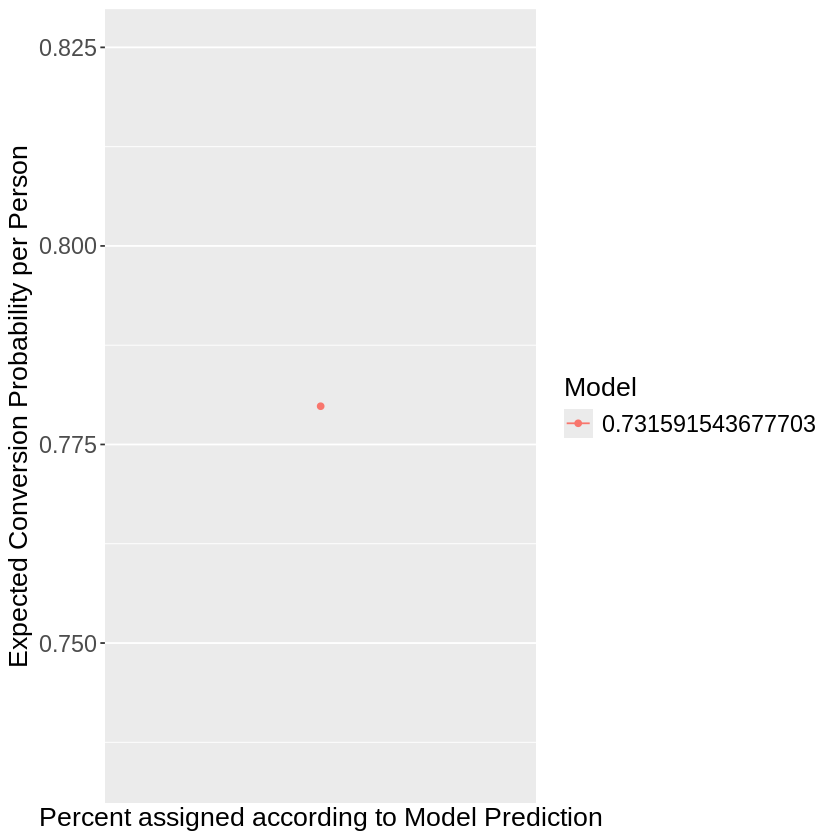

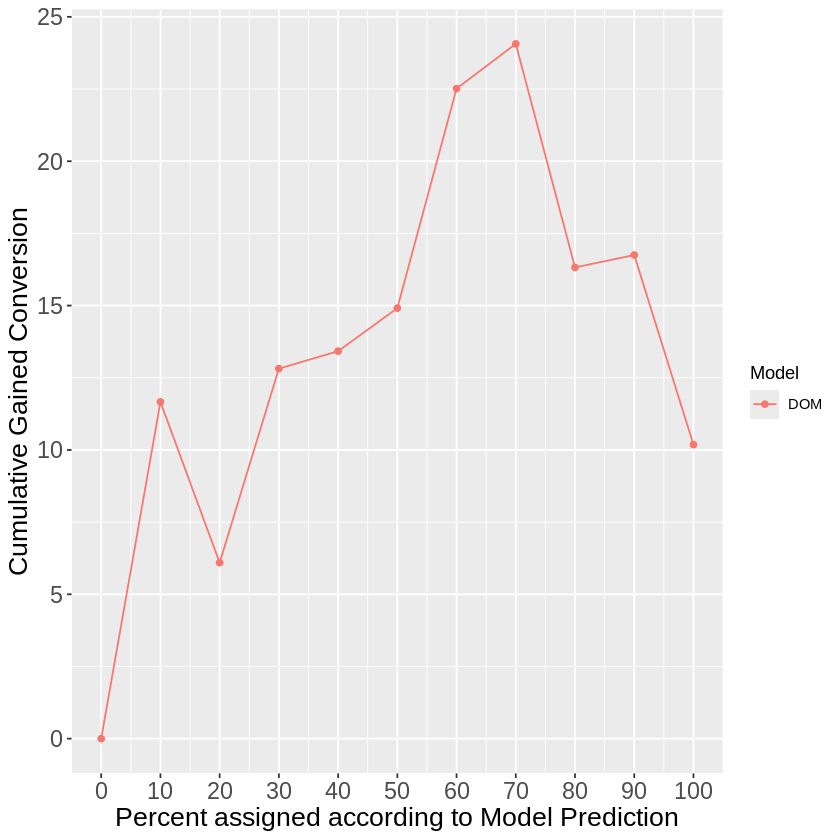

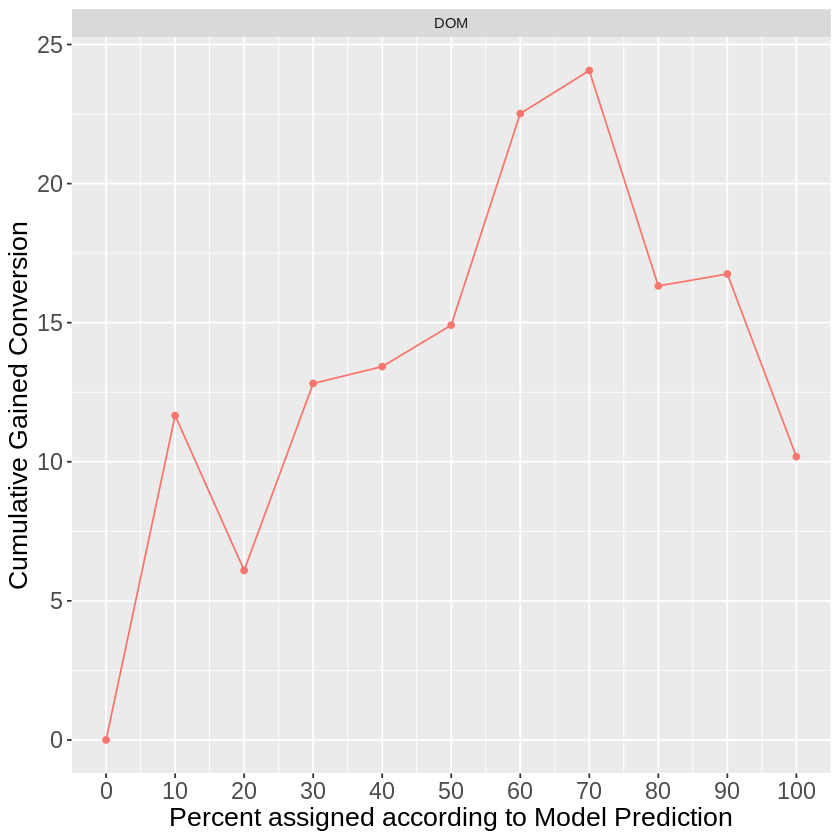

In [17]:

#Split the data into train and test set
idx <- createDataPartition(y = df[, response], p = 0.2, list = FALSE)
train <- df[-idx, ]
test <- df[idx, ]

cts_forest <- cts_train(response, control, treatment_list, train,
                        ntree = 10, nrow(train), m_try = 4,
                        n_reg = 4, min_split = 10, parallel = FALSE,)
pred <- predict_forest_df(cts_forest, test, treatment_list, control)

cts_outcomes <- expected_outcome_curve(response, control, treatment_list, pred, model = "CTS")
cts_qini <- qini_curve(pred, control, treatment_list, model_name = "CTS")



#Visualize the evaluations
visualize_outcome(rbind(cts_outcomes),
                  ylabel = "Expected Conversion Probability per Person")

visualize_qini(rbind(cts_qini), ylabel = "Cumulative Gained Conversion")

#By default all the results are displayed in one plot.
#Using the "multiplot" parameter the results can displayed side by side in individual subplots

visualize_qini(rbind(cts_qini), ylabel = "Cumulative Gained Conversion",
               multiplot = T)